## POSTPROECESSING

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import neptune
from MODULES.vae_model import *
from MODULES.utilities_visualization import show_batch, plot_tiling, plot_label_contours
from MODULES.utilities_visualization import plot_segmentation #, movie_from_resolution_sweep
from MODULES.graph_clustering import GraphSegmentation
from MODULES.utilities import QC_on_integer_mask, concordance_integer_masks, load_json_as_dict, load_obj
from MODULES.utilities_visualization import contours_from_labels, add_red_contours
import skimage.io
import skimage.morphology
from IPython.display import HTML
from matplotlib import animation

# Check versions
import torch
import numpy
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

# make sure to fix the randomness at the very beginning
torch.manual_seed(0)
numpy.random.seed(0)

python_version() --->  3.7.7
torch.__version__ -->  1.5.0


In [3]:
!git log -n 1

commit d3a1bb2e29c28e6838795b047e74000b0282f829
Author: dalessioluca <ldalessi@broadinstitute.org>
Date:   Mon Nov 2 16:03:41 2020 -0500

    clean up the graph clustering code


### Helper functions

In [96]:
def draw_contours(image: numpy.ndarray, contours: numpy.ndarray, contours_color: str = 'red') -> numpy.ndarray:
    assert isinstance(image, numpy.ndarray)
    assert isinstance(contours, numpy.ndarray)
    assert contours.dtype == bool
    if (len(image.shape) == 3) and (image.shape[-1] == 3):
        image_with_contours = image
    elif len(image.shape) == 2:
        image_with_contours = skimage.color.gray2rgb(image)
    else:
        raise Exception
    if contours_color == 'red':
        ch_index = 0
    elif contours_color == 'green':
        ch_index = 1
    elif contours_color == 'blue':
        ch_index = 2
    else:
        raise Exception("contours_color not recognized. Should be 'red' or 'green' or 'blue'")

    image_with_contours[contours, :] = 0
    image_with_contours[contours, ch_index] = numpy.max(image_with_contours)
    return image_with_contours


def plot_label_contours(label: Union[torch.Tensor, numpy.ndarray],
                        image: Union[torch.Tensor, numpy.ndarray],
                        window: Optional[tuple] = None,
                        contour_thickness: int = 2,
                        contour_color: str = 'red',
                        figsize: tuple = (24, 24),
                        experiment: Optional[neptune.experiments.Experiment] = None,
                        neptune_name: Optional[str] = None):
    _exp = experiment if experiment else neptune
    assert len(label.shape) == 2
    assert len(image.shape) == 2 or len(image.shape)==3
    
    assert len(label.shape) == 2
    if torch.is_tensor(label):
        label = label.cpu().numpy()

    if torch.is_tensor(image):
        if len(image.shape) == 3:
            image = image.permute(1, 2, 0).cpu().numpy()
        else:
            image = image.cpu().numpy()
    if len(image.shape) == 3 and (image.shape[-1] != 3):
        image = image[..., 0]

    assert image.shape[:2] == label.shape[:2]

    print(window)
    if window is None:
        window = [0, 0, label.shape[-2], label.shape[-1]]
    else:
        window = (max(0, window[0]),
                  max(0, window[1]),
                  min(label.shape[-2], window[2]),
                  min(label.shape[-1], window[3]))

    contours = contours_from_labels(label[window[0]:window[2], window[1]:window[3]], contour_thickness)
    img_with_contours = draw_contours(image=image[window[0]:window[2], window[1]:window[3]],
                                      contours=contours,
                                      contours_color=contour_color)

    fig, ax = plt.subplots(ncols=3, figsize=figsize)
    ax[0].imshow(image[window[0]:window[2], window[1]:window[3]], cmap='gray')
    ax[1].imshow(img_with_contours)
    ax[2].imshow(skimage.color.label2rgb(label=label[window[0]:window[2], window[1]:window[3]],
                                         image=image[window[0]:window[2], window[1]:window[3]],
                                         alpha=0.25, 
                                         bg_label=0))

    fig.tight_layout()
    if neptune_name is not None:
        #log_img_and_chart(name=neptune_name, fig=fig, experiment=experiment)
        log_img_only(name=neptune_name, fig=fig, experiment=_exp)
    plt.close(fig)
    return fig


def compactify_mask(mask):
    myfilter = torch.bincount(mask.reshape(-1)) > 0
    present = myfilter.to(mask.dtype)
    old_2_new = (torch.cumsum(present, dim=-1) - present[0]) * myfilter + -1*~myfilter
    new_mask = old_2_new[mask]
    return new_mask


### Load the trained model and the image

In [4]:
parameters_file = "/home/jupyter/REPOS/spacetx-research/dataset_smFISH/RUN_324/ML_parameters_MNIS-324.json"
ckpt_file = "/home/jupyter/REPOS/spacetx-research/dataset_smFISH/RUN_324/last_ckpt_MNIS-324.pt"

vae = CompositionalVae(load_json_as_dict(parameters_file))
load_from_ckpt(ckpt=file2ckpt(path=ckpt_file, device=None),
               model=vae,
               optimizer=None,
               overwrite_member_var=True)

### Load the dataset

In [10]:
preprocessed = load_obj("/home/jupyter/REPOS/spacetx-research/dataset_smFISH/streamlined_8_smFISH_stitched_OLEH.tif")
print(preprocessed._fields)
print(preprocessed.img.shape)
print(preprocessed.roi_mask.shape)

('img', 'roi_mask', 'bbox_original', 'bbox_crop')
torch.Size([1, 1, 2688, 2688])
torch.Size([1, 1, 2688, 2688])


### Compute the tiling and save to file

In [16]:
tiling = vae.segment_with_tiling(single_img=preprocessed.img[0].float(),
                                 roi_mask=preprocessed.roi_mask[0].float(),
                                 crop_size=(80,80),
                                 stride=(20,20),
                                 n_objects_max_per_patch=vae.input_img_dict["n_objects_max"],
                                 prob_corr_factor=0.0,
                                 overlap_threshold=0.3,
                                 #topk_only=False,
                                 radius_nn=10,
                                 batch_size=64)

save_obj(tiling, "tiling_smFISH_nov_20_2020.pt")
#tiling = load_obj("tiling_new.pt")
#tiling = load_obj("tiling_large.pt")
#tiling = load_obj("tiling_smFISH_nov_20_2020.pt")

Each pixel will be segmented 16 times
I am going to process 12303 patches
0 out of 192 -> batch_of_imgs.shape = torch.Size([64, 1, 80, 80])
10 out of 192 -> batch_of_imgs.shape = torch.Size([64, 1, 80, 80])
20 out of 192 -> batch_of_imgs.shape = torch.Size([64, 1, 80, 80])
30 out of 192 -> batch_of_imgs.shape = torch.Size([64, 1, 80, 80])
40 out of 192 -> batch_of_imgs.shape = torch.Size([64, 1, 80, 80])
50 out of 192 -> batch_of_imgs.shape = torch.Size([64, 1, 80, 80])
60 out of 192 -> batch_of_imgs.shape = torch.Size([64, 1, 80, 80])
70 out of 192 -> batch_of_imgs.shape = torch.Size([64, 1, 80, 80])
80 out of 192 -> batch_of_imgs.shape = torch.Size([64, 1, 80, 80])
90 out of 192 -> batch_of_imgs.shape = torch.Size([64, 1, 80, 80])
100 out of 192 -> batch_of_imgs.shape = torch.Size([64, 1, 80, 80])
110 out of 192 -> batch_of_imgs.shape = torch.Size([64, 1, 80, 80])
120 out of 192 -> batch_of_imgs.shape = torch.Size([64, 1, 80, 80])
130 out of 192 -> batch_of_imgs.shape = torch.Size([6

### Show the tiling before the graph approach

[2488, 1520, 2688, 1720]


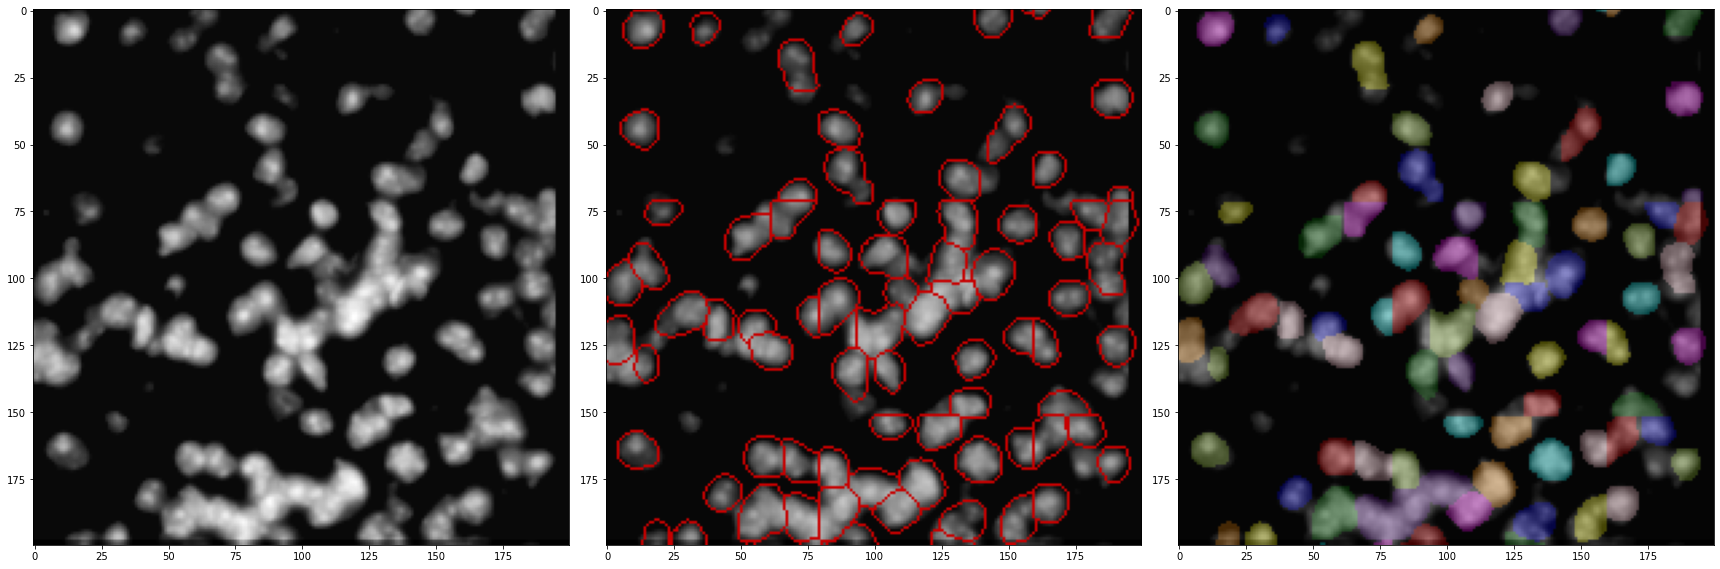

In [20]:
ix, iy, delta = 2488, 1520, 200
window = [ix, iy, ix+delta, iy+delta]

plot_label_contours(label=tiling.integer_mask[0,0],
                    image=tiling.raw_image[0],
                    window=window,
                    contour_thickness=1,
                    contour_color='red')

# Graph approach

In [21]:
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.01, normalize_graph_edges=True)
print(g.graph["total_nodes"])
print(g.graph["total_edge_weight"])
g.graph.summary()

Building the graph with python-igraph
756642
356810.4375


'IGRAPH U-W- 756642 68377937 -- \n+ attr: total_edge_weight (g), total_nodes (g), label (v), weight (e)'

### Find partition in a small region to check everything works fine

In [22]:
partition_small = g.find_partition_leiden(resolution=1000.0,
                                          window=window,
                                          min_size= 20,
                                          cpm_or_modularity="modularity",
                                          n_iterations=10) 

find partition internal


[2488, 1520, 2688, 1720]


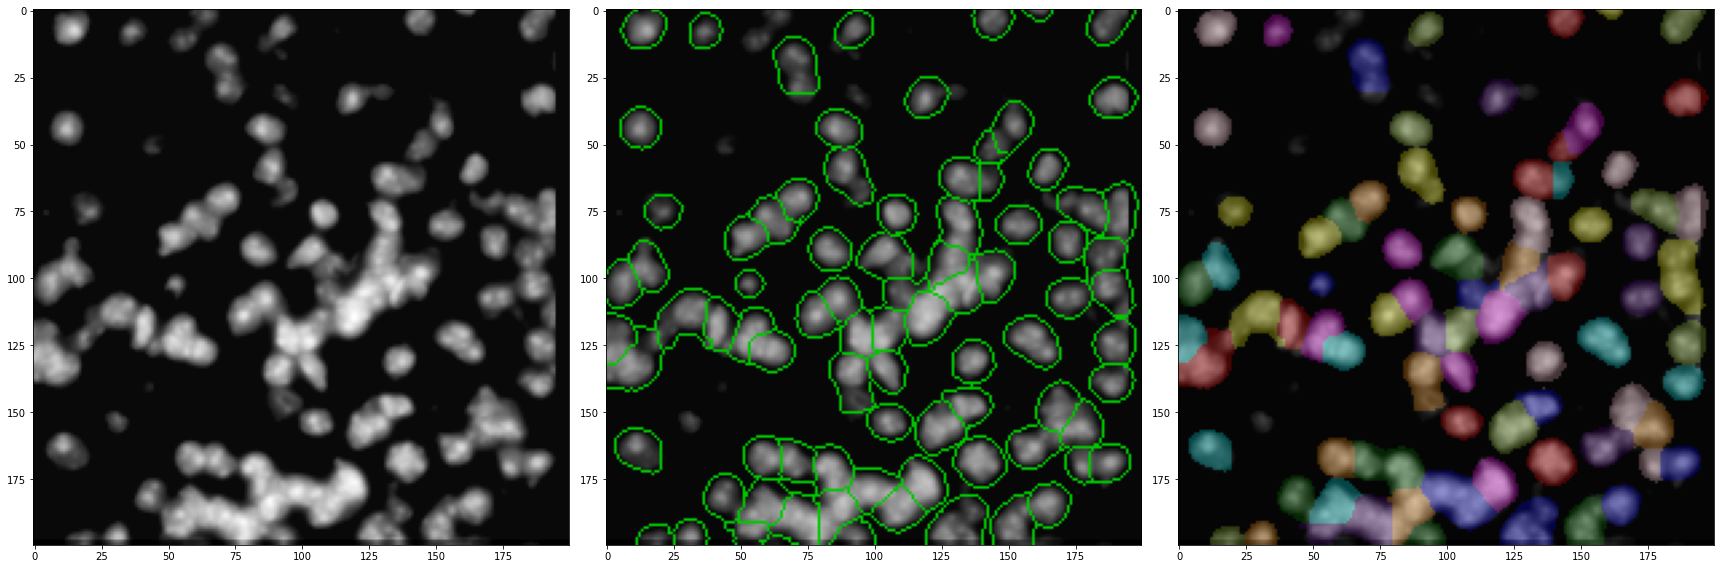

In [23]:
graph_mask_small = g.partition_2_integer_mask(partition_small)
plot_label_contours(label=graph_mask_small,
                    image=tiling.raw_image[0, 0],
                    window=window,
                    contour_thickness=1,
                    contour_color='green',
                    neptune_name=None)

### Find partition for the entire image

In [28]:
import time
time_start = time.time()
partition_all = g.find_partition_leiden(resolution=1000.0,
                                        window=None,
                                        min_size= 20,
                                        cpm_or_modularity="modularity",
                                        n_iterations=10)

print("Graph community detection time:",time.time()-time_start)
graph_mask_all = g.partition_2_integer_mask(partition_all)

find partition internal
Graph community detection time: 561.832436800003


# Paper fig1: compare segmentation before/after graph approach

raw_image.shape (200, 200)
label_no_graph.shape (200, 200)
label_with_graph.shape (200, 200)


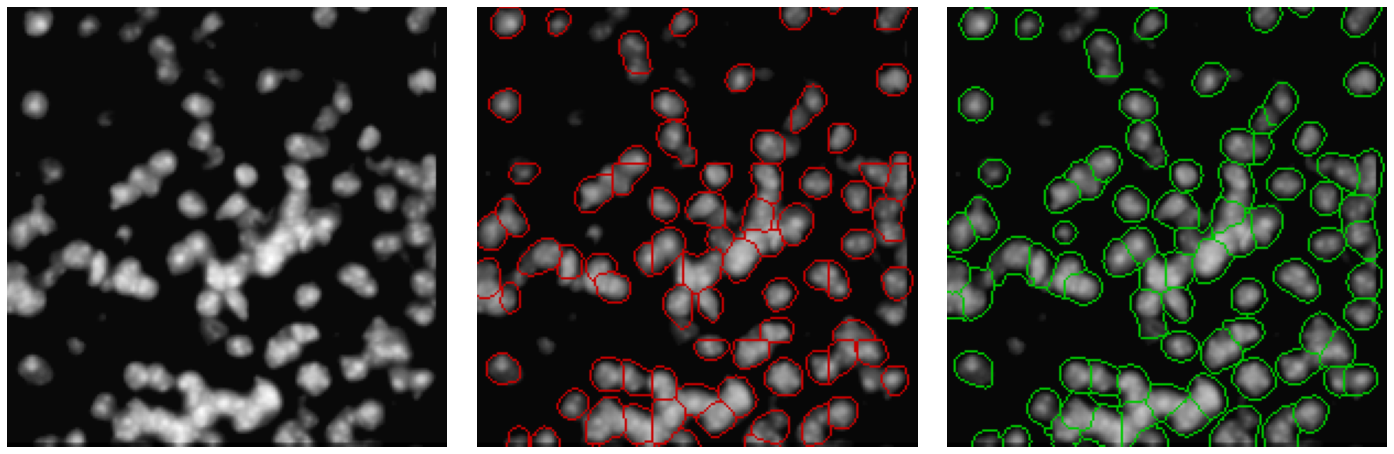

In [30]:
ix, iy, delta = 2488, 1520, 200
window = [ix, iy, ix+delta, iy+delta]

raw_image = tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]].cpu().numpy()
label_no_graph = tiling.integer_mask[0,0,window[0]:window[2], window[1]:window[3]].cpu().numpy()
label_with_graph = graph_mask_all[window[0]:window[2], window[1]:window[3]].cpu().numpy()

print("raw_image.shape", raw_image.shape)
print("label_no_graph.shape", label_no_graph.shape)
print("label_with_graph.shape", label_with_graph.shape)

assert raw_image.shape == label_no_graph.shape == label_with_graph.shape

c_no_graph = contours_from_labels(label_no_graph, contour_thickness=1)
seg_no_graph = draw_contours(image=raw_image, contours=c_no_graph, contours_color="red")

c_with_graph = contours_from_labels(label_with_graph, contour_thickness=1)
seg_with_graph = draw_contours(image=raw_image, contours=c_with_graph, contours_color="green")

fig, ax = plt.subplots(ncols=3, figsize=(20,20))

ax[0].imshow(raw_image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(seg_no_graph)
ax[1].axis('off')
ax[2].imshow(seg_with_graph)
ax[2].axis('off')

fig.tight_layout(pad=3.0)
fig.savefig("./DAPI.pdf")
fig.savefig("./DAPI.png")

# Paper fig2: show segmentation for the entire image

(2688, 2688) (2688, 2688)


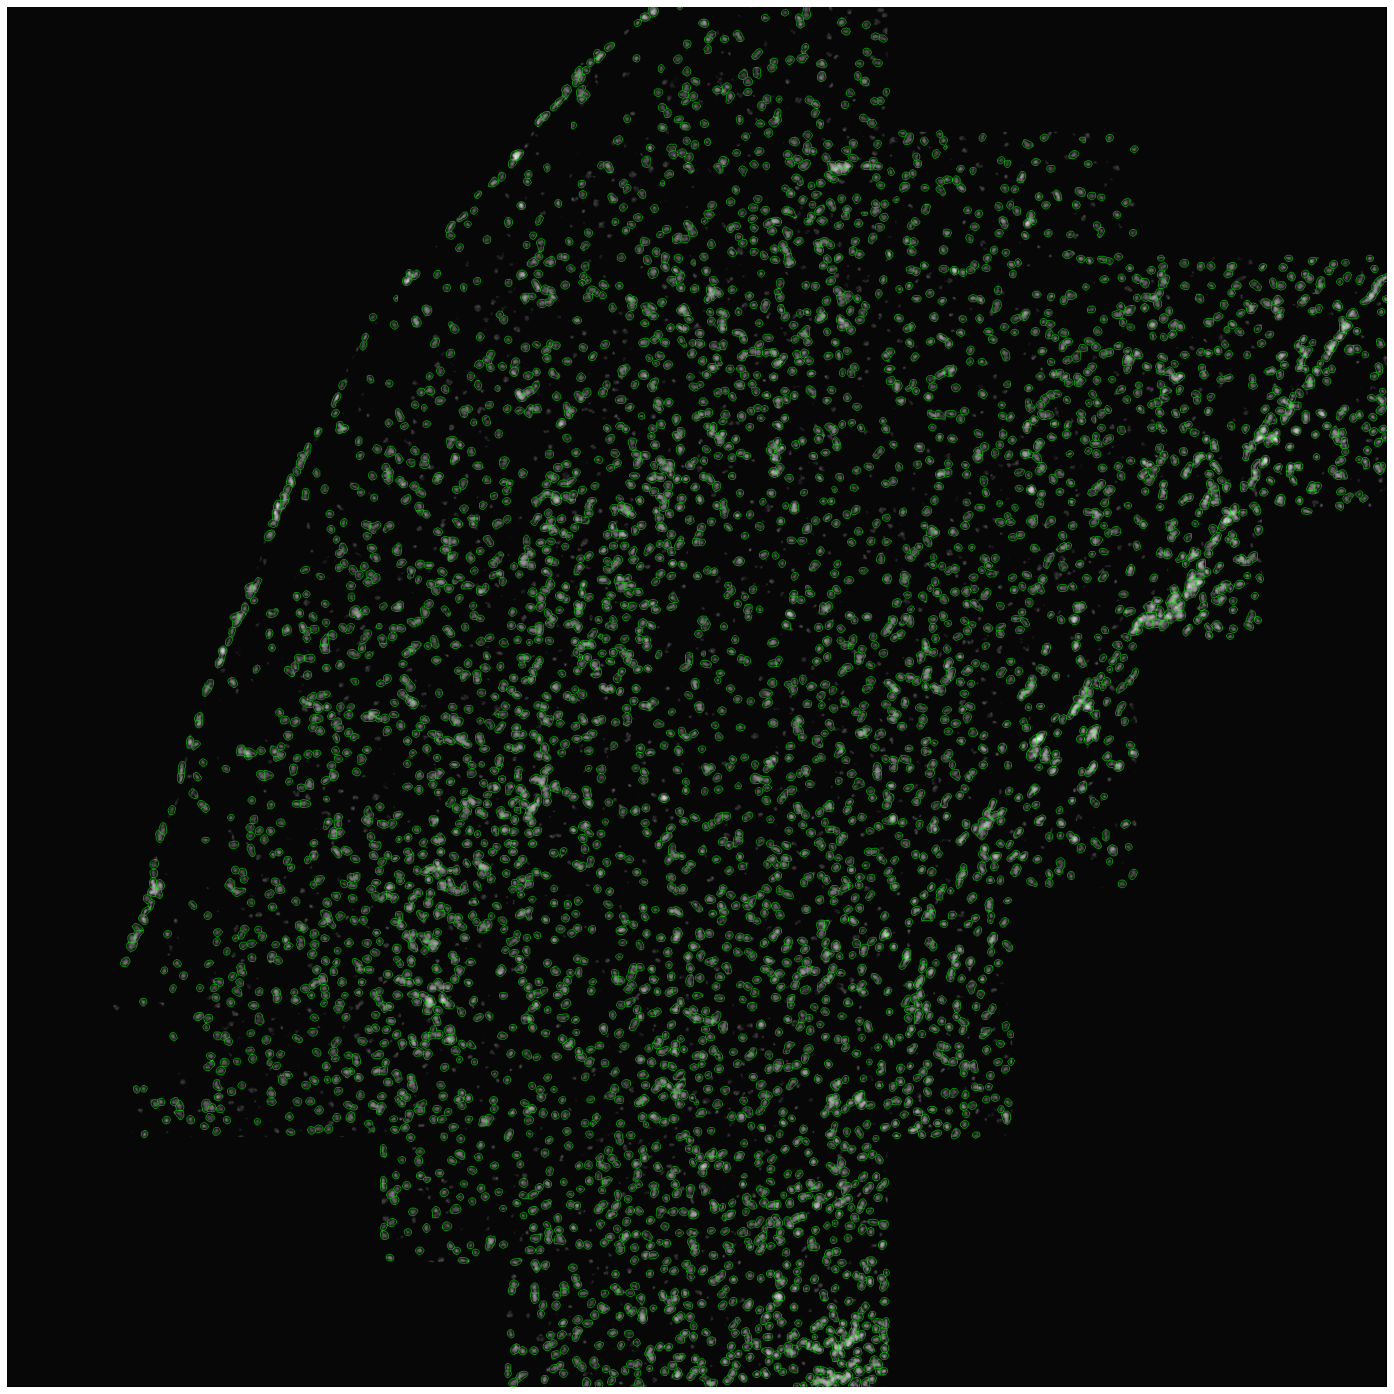

In [31]:
raw_image = tiling.raw_image[0,0].cpu().numpy()
c_with_graph = contours_from_labels(graph_mask_all.cpu().numpy(), contour_thickness=1)
print(c_with_graph.shape, raw_image.shape)
seg_with_graph = draw_contours(image=raw_image, contours=c_with_graph, contours_color="green")

fig, ax = plt.subplots(figsize=(20,20))

ax.imshow(seg_with_graph)
ax.axis('off')
fig.tight_layout(pad=3.0)
fig.savefig("./DAPI_GLOBAL.pdf")
fig.savefig("./DAPI_GLOBAL.png")

# Paper fig3: show multiple sample from the mask posterior distribution

torch.Size([16, 1, 80, 80])
torch.Size([80, 80])
torch.Size([80, 80])
(80, 80, 3)


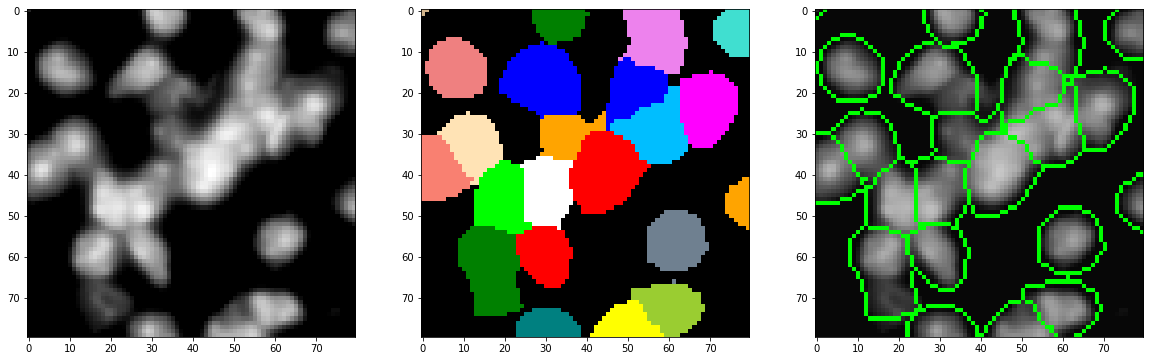

In [124]:
ix, iy, delta = 2563, 1595, 80

img_to_segment=tiling.raw_image[:,:,ix:ix+delta,iy:iy+delta].expand(16,-1,-1,-1)
print(img_to_segment.shape)

cropped_img=img_to_segment[0,0]
consensus_mask=compactify_mask(graph_mask_all[ix:ix+delta,iy:iy+delta])
consensus_contours=seg_with_graph[ix:ix+delta,iy:iy+delta]
print(cropped_img.shape)
print(consensus_mask.shape)
print(consensus_contours.shape)

list_of_colors = ['red','blue','green','orange', 'violet',
                  'yellow', 'fuchsia', 'deepskyblue', 'lime', 'slategray', 
                  'white', 'salmon', 'lightcoral', 'tan', 'turquoise', 'moccasin',
                 'teal', 'yellowgreen']

fig, ax = plt.subplots(ncols=3, figsize=(20,20))
ax[0].imshow(cropped_img, cmap='gray')
ax[1].imshow(skimage.color.label2rgb(label=consensus_mask.cpu().numpy(), 
                                     bg_label=0, 
                                     colors=list_of_colors))
ax[2].imshow(consensus_contours)

In [110]:
output = vae.process_batch_imgs(imgs_in=img_to_segment.cuda(),
                                generate_synthetic_data=False,
                                topk_only=False,
                                draw_image=True,
                                draw_bg=False,
                                draw_boxes=True,
                                verbose=False,
                                noisy_sampling=True,
                                prob_corr_factor=0,
                                overlap_threshold=0.3,
                                n_objects_max=25)

In [111]:
bg = 1 - torch.sum(output.inference.mixing, dim=-5, keepdim=True)
mixing_with_bg = torch.cat((bg, output.inference.mixing), dim=-5).permute(1,2,3,4,0).clone()
print(mixing_with_bg.shape)
print(mixing_with_bg.device)

torch.Size([16, 1, 80, 80, 26])
cuda:0


In [112]:
m = torch.distributions.categorical.Categorical(probs=mixing_with_bg.clamp(min=0).cpu())

In [113]:
sample_mask = m.sample()
print(img_to_segment.shape)

torch.Size([16, 1, 80, 80])
torch.Size([16, 1, 80, 80])


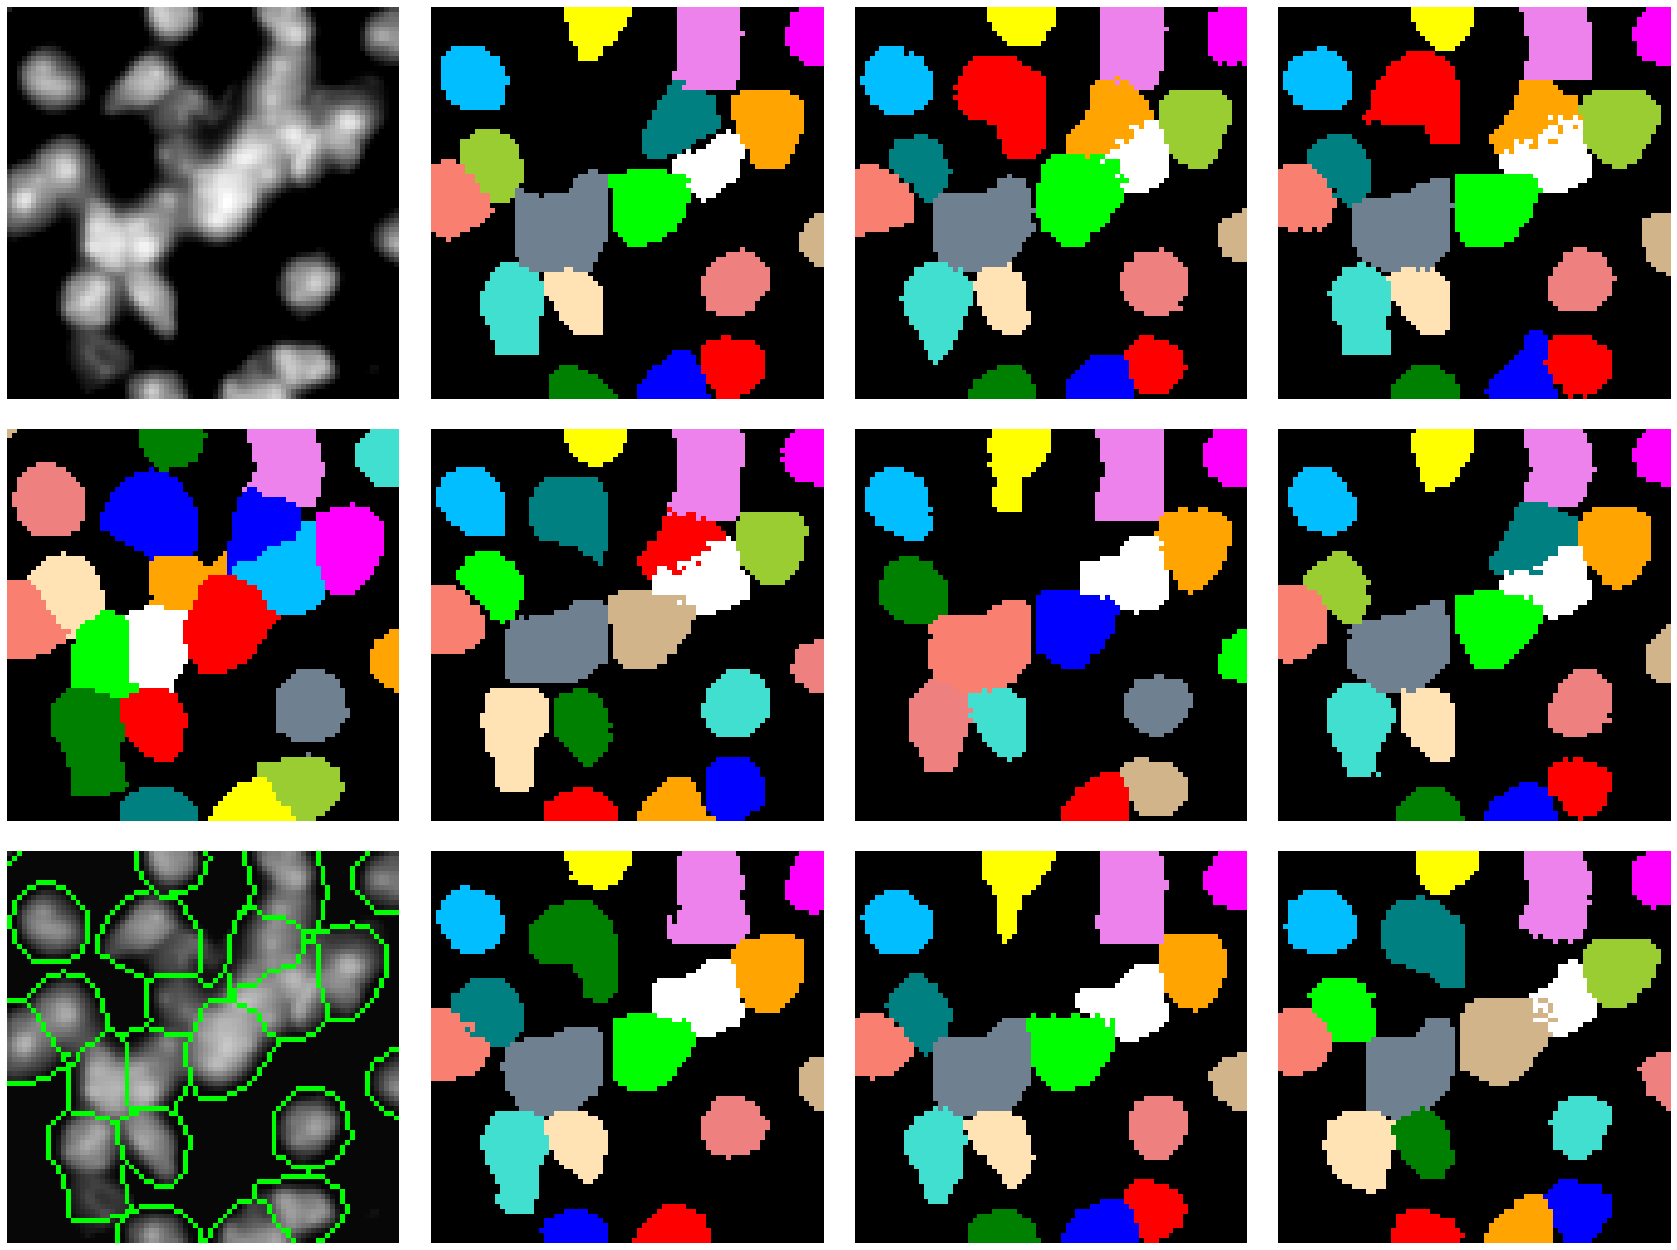

In [132]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(24,18))
n=-1
ax[0,0].imshow(cropped_img, cmap='gray')
ax[1,0].imshow(skimage.color.label2rgb(label=consensus_mask.cpu().numpy(), 
                                       bg_label=0, 
                                       colors=list_of_colors))
ax[2,0].imshow(consensus_contours)
ax[0,0].axis("off")
ax[1,0].axis("off")
ax[2,0].axis("off")

for r in range(3):
    for c in range(1,4):
        n += 1
        ax[r,c].imshow(skimage.color.label2rgb(label=compactify_mask(sample_mask[n,0]).cpu().numpy(),
                                               bg_label=0,
                                               colors=list_of_colors))
        ax[r,c].axis("off")
fig.tight_layout(pad=3.0)
fig.savefig("./posterior_samples.pdf")
fig.savefig("./posterior_samples.png")

### Figure 4: different consensus segmentation depending on the resolution parameter

In [ ]:
print(window)

In [133]:
partition_small_1000 = g.find_partition_leiden(resolution=1000.0,
                                               window=window,
                                               min_size= 20,
                                               cpm_or_modularity="modularity",
                                               n_iterations=10) 

partition_small_500 = g.find_partition_leiden(resolution=500.0,
                                               window=window,
                                               min_size= 20,
                                               cpm_or_modularity="modularity",
                                               n_iterations=10) 

partition_small_100 = g.find_partition_leiden(resolution=100.0,
                                               window=window,
                                               min_size= 20,
                                               cpm_or_modularity="modularity",
                                               n_iterations=10) 


find partition internal
find partition internal
find partition internal


In [140]:
raw_image = tiling.raw_image[0,0,window[0]:window[2],window[1]:window[3]].cpu().numpy()
mask_1000 = g.partition_2_integer_mask(partition_small_1000)[window[0]:window[2],window[1]:window[3]].cpu().numpy()
mask_500 = g.partition_2_integer_mask(partition_small_500)[window[0]:window[2],window[1]:window[3]].cpu().numpy()
mask_100 = g.partition_2_integer_mask(partition_small_100)[window[0]:window[2],window[1]:window[3]].cpu().numpy()

seg_100 = draw_contours(image=raw_image, 
                         contours=contours_from_labels(mask_100, contour_thickness=1), 
                         contours_color="green")

seg_500 = draw_contours(image=raw_image, 
                         contours=contours_from_labels(mask_500, contour_thickness=1), 
                         contours_color="green")

seg_1000 = draw_contours(image=raw_image, 
                         contours=contours_from_labels(mask_1000, contour_thickness=1), 
                         contours_color="green")


print(raw_image.shape)
print(mask_1000.shape)
print(mask_500.shape)
print(mask_100.shape)

(200, 200)
(200, 200)
(200, 200)
(200, 200)


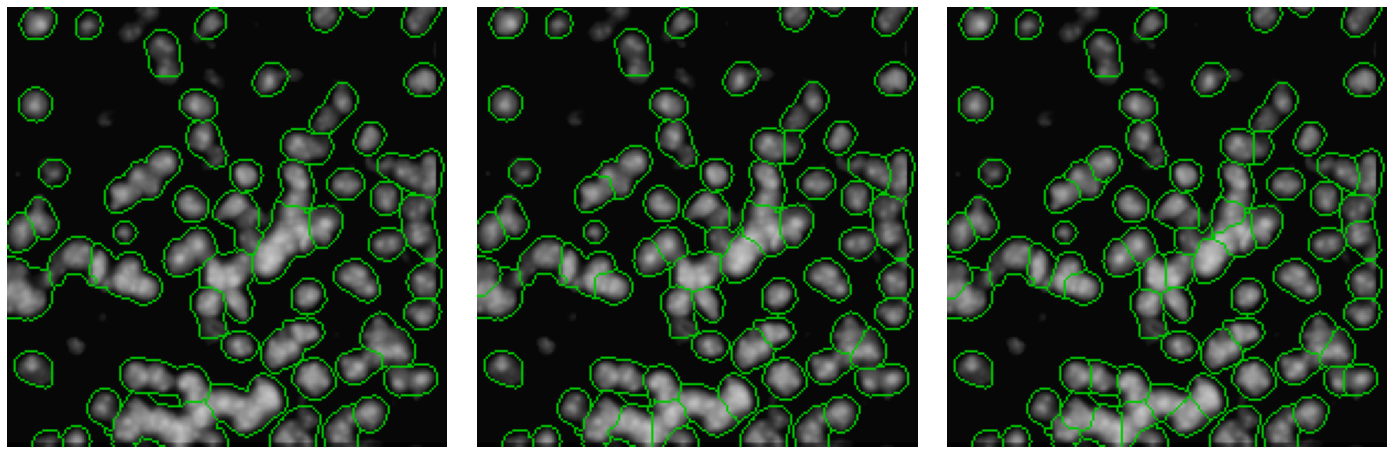

In [141]:
fig, ax = plt.subplots(ncols=3, figsize=(20,20))

ax[0].imshow(seg_100)
ax[0].axis('off')
ax[1].imshow(seg_500)
ax[1].axis('off')
ax[2].imshow(seg_1000)
ax[2].axis('off')

fig.tight_layout(pad=3.0)
fig.savefig("./resolution.pdf")
fig.savefig("./resolution.png")